# Keyphrase extractors

Toponymy makes use of keyphrases to provide clear topical information about the content of potential clusters of objects. The means of ranking potential keyphrases is handled within Toponymy itself, but the task of extracting candidate keyphrases from text associated to objects is handled by a KeyphraseBuilder. This tutorial will work through what KeyphraseBuilders are, and how they may be used and tuned to your needs.

To begin, let's load some libraries and collect data to demonstrate how KeyphraseBuilders work.

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

For data we will collect a subset of the arxiv ml dataset which compiles titles and abstracts of ArXiv articles about machine learning. You can consult the [dataset card on Huggingface] for more details on its composition. To keep to a manageable size we'll simply grab one of the 8 eight chunks that make up the full dataset.

In [2]:
arxiv_ml_df = pd.read_parquet("hf://datasets/lmcinnes/arxiv_ml/data/train-00000-of-00008-f3c9b137f969d545.parquet")

In [3]:
arxiv_ml_df.head()

,date_created,abstract,title,categories,arxiv_id,year,embedding_str,embedding,data_map
0,2007-04-01 13:06:50,The intelligent acoustic emission locator is...,Intelligent location of simultaneously active ...,cs.NE cs.AI,0704.0047,2007,# Intelligent location of simultaneously activ...,"[-0.04404345899820328, 0.028888946399092674, -...","[9.242573738098145, 2.837263584136963]"
1,2007-04-01 18:53:13,Part I describes an intelligent acoustic emi...,Intelligent location of simultaneously active ...,cs.NE cs.AI,0704.0050,2007,# Intelligent location of simultaneously activ...,"[-0.03380154073238373, 0.005963773000985384, -...","[9.297958374023438, 2.8726723194122314]"
2,2007-04-03 02:08:48,This paper discusses the benefits of describ...,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,0704.0304,2007,# The World as Evolving Information\n\n This ...,"[-0.005738923791795969, 0.01626133918762207, 0...","[3.5662941932678223, 10.24143123626709]"
3,2007-04-05 02:57:15,The problem of statistical learning is to co...,Learning from compressed observations,cs.IT cs.LG math.IT,0704.0671,2007,# Learning from compressed observations\n\n T...,"[0.004663723520934582, 0.02371317893266678, -0...","[-0.9903357625007629, 7.9114227294921875]"
4,2007-04-06 21:58:52,"In a sensor network, in practice, the commun...",Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,0704.0954,2007,# Sensor Networks with Random Links: Topology ...,"[0.03113919124007225, 0.01722194068133831, -0....","[-2.087822675704956, 9.253089904785156]"


In [4]:
document_vectors = np.stack(arxiv_ml_df["embedding"].values)
clusterable_vectors = np.stack(arxiv_ml_df["data_map"].values)

To work with KeyphraseBuilders we will need to import the ``KeyphraseBuilder`` class from ``toponymy.keyphrases``.

In [5]:
from toponymy.keyphrases import KeyphraseBuilder

We can now construct a ``KeyphraseBuilder``. For an initial builder we will specify a number of the parameters that can be set. A first option is the ``object_to_text`` which should either be a function that can convert objects from your source collection into text (OpenBlip for images, or whisper for voice audio for example) or ``None`` if the input is text already. Since we have text, we'll set ``object_to_text`` to ``None``. We can also specify an ``ngram_range`` which will determine the potential length of keyphrases we will allow -- essentially this should be the range of how long in words (or tokens -- see further on in the tutorial) a keyphrase should be. You can specify the ``ngram_range`` as a tuple of shortest length to longest length of keyphrase. Here we'll be expansive, and allow keyphrases of length 1, all the way up to 8 word long keyphrases. Note that the longer the keyphrases you allow, the more expensive the keyphrase computation becomes. An important option if you are allowing long keyphrases is ``max_features`` which controls the maximum total number of keyphrases we will allow and track. We'll allow up to thirty thousand possible keyphrases. The ``token_pattern`` is a regex used to break the text up into "words". The default ``token_pattern`` is being used below, and this is likely sufficient for most text in languages using that have space-delimited word boundaries. You may want to explore other options for Asian languages or more complex text data. Finally ``min_occurrences`` determines the minimum number of times a potential keyphrase must be encountered in the corpus before being considered. For this example we'll set it to 20 so we only collect frequently used keyphrases. Setting ``verbose=True`` will ensure we get progress updates as the keyphrases are being constructed.

In [6]:
kp_builder = KeyphraseBuilder(
    object_to_text=None,
    ngram_range=(1,8),
    max_features=30_000,
    token_pattern="(?u)\\b\\w[-'.@*\\w]+\\b",
    min_occurrences=20,
    verbose=True,
)

To make use the of the keyphrase builder we call the ``fit`` method and pass it an iterable of strings. Since we have ``verbose=True`` it will give us processing updates as it goes.

In [7]:
kp_builder.fit(arxiv_ml_df.embedding_str)

Building keyphrase matrix ... 
Chunking into 2 chunks of size 20000 for keyphrase identification.
Combining count dictionaries ...
Found 19806 keyphrases.
Chunking into 2 chunks of size 20000 for keyphrase count construction.
Combining count matrix chunks ...


Once the keyphrase builder has been fit it acquires two new attributes: ``keyphrase_list_`` and ``object_x_keyphrase_matrix_``. The ``keyphrase_list_`` is just a list of all the keyphrases found. If you note the verbose-mode output above you'll see that we found 19806 keyphrases. If we check the list of the ``keyphrase_list_`` you'll see it has 19806 entries.

In [8]:
len(kp_builder.keyphrase_list_)

19806

Why did we only find 19806 keyphrases when we asked for a maximum of 30,000 and chose a large enough ngram-range that we would expect to see that many? The ``min_occurrences`` of 20 means we will only pick keyphrases that are used *at least* 20 times. That number is significantly smaller than all possible 8-grams, and in our case works out to be 19806. We can look at entries in the ``keyphrase_list_`` to see what it contains. So make it more interesting let's look at entries that have at least seven words:

In [9]:
[x for x in kp_builder.keyphrase_list_ if len(x.split()) >= 7]

['theory and practice of logic programming tplp',
 'appear in theory and practice of logic',
 'appear in theory and practice of logic programming',
 'uncertainty in artificial intelligence which was held',
 'demonstrate the effectiveness of the proposed approach',
 'experiments on both synthetic and real data',
 'compared to the state of the art',
 'experimental results show that the proposed method']

What about the ``object_x_keyphrase_matrix_``? It stores a record of how often each keyphrase occurs for each object. In our case, where objects are just documents, this is just a matrix of how often keyphrases occur in documents. This is stored as a sparse matrix:

In [10]:
kp_builder.object_x_keyphrase_matrix_

<Compressed Sparse Row sparse matrix of dtype 'int32'
	with 2693613 stored elements and shape (35227, 19806)>

We can visualize this matplotlib's spy-plot functionality:

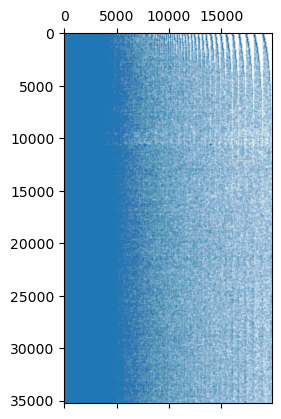

In [11]:
plt.spy(kp_builder.object_x_keyphrase_matrix_, markersize=0.01)

The odd striping in the top right occurs because the keyphrases are order from left to right by how often they occur in the corpus as a whole, but in the case of ties (which there will be for less frequent keywords) they are simply ordered by the order they were encountered during processing, and thus according to the order of the documents themselves. We can fix that by reordering out rows by relative similarity.

In [12]:
import sklearn.decomposition
import scipy.cluster.hierarchy

To make this tractable computationally we'll just use a truncatedSVD representation of the sparse vectors for clustering with single linkage clustering, and then place the rows in depth-first order traversal of the clustering hierarchy.

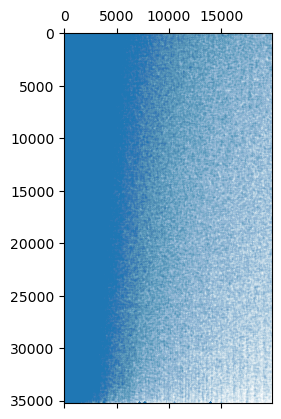

In [13]:
compressed_keyphrase_rep = sklearn.decomposition.TruncatedSVD(n_components=128).fit_transform(kp_builder.object_x_keyphrase_matrix_)
hierarchy = scipy.cluster.hierarchy.single(compressed_keyphrase_rep)
reordered_matrix = kp_builder.object_x_keyphrase_matrix_[scipy.cluster.hierarchy.leaves_list(hierarchy), :]
plt.spy(reordered_matrix, markersize=0.01)

This process works well enough for latin scripts, but may not work so well for asian languages or other special purpose text where space splitting or simple regexes will not work well for breaking up text. Fortunately the keyphrase builder can work with general tokenizers from the ``tokenizers`` library (or, indeed, any tokenizer object that has suitable encode and decode functions). Here we will stick with the same dataset, but use a different tokenizer -- we'll use the very standard ``bert-base-uncased`` tokenizer used for most BERT based models.

In [14]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_pretrained("bert-base-uncased")

To make use of a tokenizer we simply pass it in with the ``tokenizer`` keyword argument. This will override any ``token_pattern`` or similar, and use the tokenizer for breaking test into pieces. Let's try it out with some different params in our keyphase builder -- no ``min_occurrences``, a smaller ``ngram_range``, but a larger ``max_features``.

In [15]:
kp_builder = KeyphraseBuilder(
    object_to_text=None,
    tokenizer=tokenizer,
    ngram_range=(1,6),
    max_features=40_000,
    verbose=True,
)

As before we simply ``fit`` the model to get results.

In [16]:
kp_builder.fit(arxiv_ml_df.embedding_str)

Building keyphrase matrix ... 
Chunking into 2 chunks of size 20000 for keyphrase identification.
Combining count dictionaries ...
Found 40000 keyphrases.
Chunking into 2 chunks of size 20000 for keyphrase count construction.
Combining count matrix chunks ...


A spy plot of the ``object_keyphrase_matrix_`` shows a much larger and denser array of keyword usage.

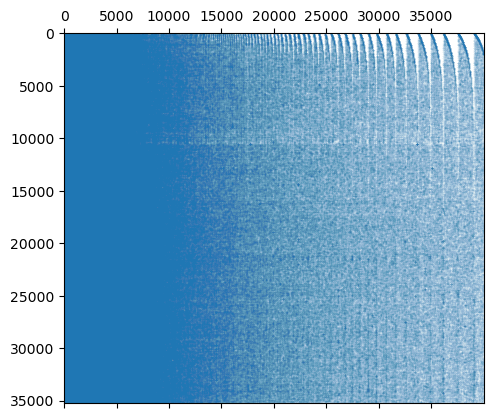

In [17]:
plt.spy(kp_builder.object_x_keyphrase_matrix_, markersize=0.01)

We still get the striping based on frequency of occurrence ties. Let's clean that up...

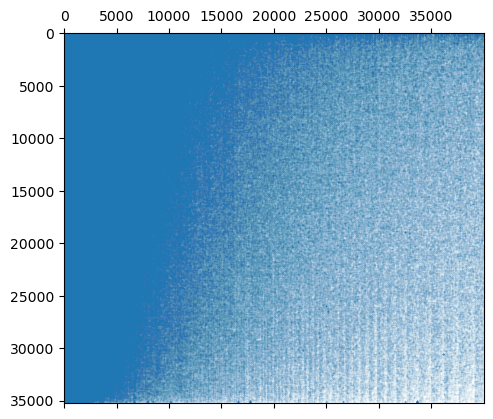

In [18]:
compressed_keyphrase_rep = sklearn.decomposition.TruncatedSVD(n_components=128).fit_transform(kp_builder.object_x_keyphrase_matrix_)
hierarchy = scipy.cluster.hierarchy.single(compressed_keyphrase_rep)
reordered_matrix = kp_builder.object_x_keyphrase_matrix_[scipy.cluster.hierarchy.leaves_list(hierarchy), :]
plt.spy(reordered_matrix, markersize=0.01)

We can now see a little  better that there are some documents that contain a lot of our keyphrases, tending downward to the bottom few documents that are much sparser. This generally higher density is to be expected, since tokens from the ``bert-base-uncased`` model are sub-word tokens, so even a single word may be made up of multiple tokens (and thus an ngram for some larger n), and the small subword tokens may occur a lot in a document that does not otherwise parse cleanly. We can get some idea of this by looking at the generated keyphrases -- let's look at the first ten keyphrases (the most common ones), and the last ten keyphrases (to get an idea of what the less obvious/common keyphrases are).

In [19]:
kp_builder.keyphrase_list_[:10]

['.', ',', '-', '#', ')', '##s', '(', 'data', '', '$']

Because the tokenizer doesn't break on words, but rather pulls out tokens we capture a lot of punctuation (which is obviously the most common occurrence compared to actual specific words), and very common subwords (``##s`` denotes a plutal suffix -- the ``##`` maker in the token implies this is an subword that attaches at the end of a word). Still, these are only candidate keyphrases, so this need not be a problem, depending on how exactly we go about selecting keyphrases. More importantly this is a much more robust approach that should be able to work well with other languages and specialist text for which you can find (or train) a tokenizer more easily than you can construct a suitable regex.

The last 10 keyphrases are also perhaps instructive:

In [20]:
kp_builder.keyphrase_list_[-10:]

['upper - bound',
 'ow',
 'background noise',
 'detection :',
 '# determini',
 '# deterministic',
 'carried out using',
 ', engineering',
 'corrects',
 'hyper - parameters.']

Here we see words and phrases being picked out, and so we are definitely getting the kinds of things we would like from this approach. Mostly what this tells us is that the left-hand side of the ``object_x_keyphrase_`` matrix is not so useful (something that keyphrase selection techniques below will successfully handle). In practice we can fix this somewhat by simply asking for for keyphrases that use *at least* four tokens, avoiding the short punctuation singleton tokens. We can also boost the ``min_occurrences`` as well. 

In [21]:
kp_builder = KeyphraseBuilder(
    object_to_text=None,
    tokenizer=tokenizer,
    ngram_range=(4,8),
    max_features=20_000,
    min_occurrences=10,
    verbose=True,
)
kp_builder.fit(arxiv_ml_df.embedding_str)
kp_builder.keyphrase_list_[:10], kp_builder.keyphrase_list_[-10:]

Building keyphrase matrix ... 
Chunking into 2 chunks of size 20000 for keyphrase identification.
Combining count dictionaries ...
Found 20000 keyphrases.
Chunking into 2 chunks of size 20000 for keyphrase count construction.
Combining count matrix chunks ...


(['. in this paper',
  '. in this paper,',
  'state - of -',
  '- of - the -',
  'state - of - the -',
  '- the - art',
  '- of - the - art',
  'state - of - the - art',
  'probabilistic',
  'convolution'],
 ['discriminant analysis.',
  '##ly decomposa',
  '##ly decomposable',
  '# calib',
  '##ly reweighted least squares',
  '##eratively reweighted least squares',
  'iteratively reweighted least squares',
  '2 } { \\',
  '( 1 - \\ epsilon',
  '1 - \\ epsilon )'])

As you can see we have some better selections of the most common keyphrases here (is it really a surprise that "state-of-the-art" and "in this paper" variants are what top the list from a selection of machine learning papers?)

Let's now look at how keyphrases are selected from the candidate lists, and how that can still work well despite having common words like "the" and "is" among candidate keyphrases.

## Selecting keyphrases to represent clusters

While we are looking at keyphrases, let's look at the different ways that are available within Toponymy for selecting keyphrases to represent a cluster. To save time and work we'll build everything once (clusters, keyphrases, keyphrase embeddings) and then run the different functions to extract keyphrases in different ways. In practice if you wish use different keyphrase extraction techniques within Toponymy as a whole you can specify the method as a ``keyphrase_method`` keyword argument in the Toponymy class' ``fit`` method. You can specity the keykeyphrase method as one of:
  * ``keyphrase_method="information_weighted"`` (the default)
  * ``keyphrase_method="central"``
  * ``keyphrase_method="bm25"``

To try out each of the different methods we'll need clusters, and vector embeddings of all the keyphrases (for semantic comparisons between keyphrases during selection).

In [22]:
from toponymy.toponymy import ToponymyClusterer
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

/work/home/lmmcinn/.conda/envs/toponymy_docs/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now we can build all the cluster layers.

In [23]:
layers, tree = ToponymyClusterer(verbose=True).fit_predict(clusterable_vectors=clusterable_vectors, embedding_vectors=document_vectors)

Layer 0 found 750 clusters
Layer 1 found 215 clusters
Layer 2 found 59 clusters
Layer 3 found 16 clusters


We will need candidate keyphrases and the object-by-keyphrase count matrix, so let's build that with a keyphrase builder. We will also need embeddings of all the keyphrases so we will construct that now as well.

In [24]:
kp_builder = KeyphraseBuilder(
    object_to_text=None,
    token_pattern="(?u)\\b\\w[-'.@*_$()&\\w]+\\b",
    ngram_range=(2,6),
    max_features=40_000,
    verbose=True,
)
kp_builder.fit(arxiv_ml_df.embedding_str)
keyphrase_vectors = embedding_model.encode(kp_builder.keyphrase_list_, show_progress_bar=True)

Building keyphrase matrix ... 
Chunking into 2 chunks of size 20000 for keyphrase identification.
Combining count dictionaries ...
Found 40000 keyphrases.
Chunking into 2 chunks of size 20000 for keyphrase count construction.
Combining count matrix chunks ...


Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Now let's import the functions used for the different keyphrase selection methods:
 * information_weighted_keyphrases
 * central_keyphrases
 * bm25_keyphrases

In [25]:
from toponymy.keyphrases import information_weighted_keyphrases, central_keyphrases, bm25_keyphrases

We will start with the information weighted approach. This method can be thought of as a more advanced version of a class-based TF-IDF scoring approach. For each keyphrase we generate an estimate of the number of bits of information gained by considering the distribution of usage of this keyword across clusters (in a given layer) over the expected distribution of keyphrase usage in general across clusters. We then weight the number number of occurrences of keyphrases in terms of the new units of bits of information per keyphrase, and select the highest information keyphrases per cluster. We then run some extra passes to pick out the longest version of keyphrases in that list (so if "state of the", "of the art", and "state of the art" all occur in the list, we'll simply use "state of the art"), and to ensure diversity among the keyphrases (so we don't pick multiple slight semantic variations of the same keyphrase). We do not need to worry about all of that however; we can pass the relevant information to the ``information_weighted_keyphrases`` function and let it do the work.

In [26]:
keyphrases = information_weighted_keyphrases(
    layers[0].cluster_labels,
    kp_builder.object_x_keyphrase_matrix_,
    kp_builder.keyphrase_list_,
    keyphrase_vectors,
    embedding_model,
)

What we get out is a list of lists of keyphrases, one list of keyphrases per cluster. Rather than going through all the clusters, let's just pick a couple, and look at the keyphrases we get:

In [27]:
keyphrases[0]

['american sign language',
 'propositional dynamic logic',
 'language translation',
 'language recognition',
 'problem of recognizing',
 'motor theory',
 'written text',
 'number of reasons',
 'annotation framework',
 'facial expression',
 'fields using',
 'expressive language',
 'technical terms',
 'video sequences',
 'computer generated',
 'paper explores the use']

We can infer that this is likely a cluster of papers related to sign language detection and translation. We can look at some of the titles from this cluster to check:

In [28]:
arxiv_ml_df.title.values[layers[0].cluster_labels == 0]

array(['Sign Language Tutoring Tool',
       'Statistical Sign Language Machine Translation: from English written text   to American Sign Language Gloss',
       'Toward a Motor Theory of Sign Language Perception',
       'Toward an example-based machine translation from written text to ASL   using virtual agent animation',
       'SignsWorld; Deeping Into the Silence World and Hearing Its Signs (State   of the Art)',
       'Recognizing Static Signs from the Brazilian Sign Language: Comparing   Large-Margin Decision Directed Acyclic Graphs, Voting Support Vector Machines   and Artificial Neural Networks',
       'Extension of hidden markov model for recognizing large vocabulary of   sign language',
       'A hybrid formalism to parse Sign Languages',
       'Sign Language Gibberish for syntactic parsing evaluation',
       'Implementation of an Automatic Sign Language Lexical Annotation   Framework based on Propositional Dynamic Logic',
       'Sign Language Lexical Recognition With P

And here is a different cluster:

In [29]:
keyphrases[128]

['anomaly detection algorithms',
 'one-class support vector',
 'shown to be asymptotically',
 'detection we propose',
 'kernel density estimators',
 'algorithm for high',
 'novel non-parametric',
 'neighbor graphs',
 'scoring function',
 'multiple criteria',
 'maximum entropy discrimination',
 'particle physics',
 'unknown underlying',
 'regularization problems',
 'nominal data',
 'sloan digital sky survey']

One can presume this is primarily about anomaly detection, particularly in time series and networks. Again we can check the titles from the cluster:

In [30]:
arxiv_ml_df.title.values[layers[0].cluster_labels == 128]

array(['Anomaly Detection with Score functions based on Nearest Neighbor Graphs',
       'Multi-criteria Anomaly Detection using Pareto Depth Analysis',
       'Anomaly Classification with the Anti-Profile Support Vector Machine',
       'One-Class Support Measure Machines for Group Anomaly Detection',
       'Scalable Anomaly Detection in Large Homogenous Populations',
       'Near-optimal Anomaly Detection in Graphs using Lovasz Extended Scan   Statistic',
       'Toward Supervised Anomaly Detection',
       'A Spectral Framework for Anomalous Subgraph Detection',
       'A Rank-SVM Approach to Anomaly Detection',
       'One-Class Support Measure Machines for Group Anomaly Detection',
       'GLAD: Group Anomaly Detection in Social Media Analysis- Extended   Abstract',
       'Multi-Level Anomaly Detection on Time-Varying Graph Data',
       'Multi-view Anomaly Detection via Probabilistic Latent Variable Models',
       'Less is More: Building Selective Anomaly Ensembles',
       'A

Now let's look at the central keyphrases approach. In this case we rely on the embedding vectors of the keyphrases, and find the vectors that are closest to the overall center of all the embeddings of keyphrases used in the given cluster. This can be fairly efficient and can get to core keyphrases, but also has some potential drawbacks. After selecting the central keyphrases we apply similar post-processing as before to find long keyphrases that are fairly diverse in content.

In [31]:
c_keyphrases = central_keyphrases(
    layers[0].cluster_labels,
    kp_builder.object_x_keyphrase_matrix_,
    kp_builder.keyphrase_list_,
    keyphrase_vectors,
    embedding_model,
)

Let's look at the output for the same clusters as before and we can get some sense of how central keyphrases compare.

In [32]:
c_keyphrases[0]

['american sign language',
 'language text',
 'natural language processing',
 'gesture recognition',
 'automatic speech recognition',
 'expressive language',
 'facial expressions',
 'able to represent',
 'conditional random fields',
 'paper presents',
 'using computer',
 'future works',
 'directed acyclic graph',
 'motor theory',
 'vice versa',
 'specifically we employ']

As you can see we get keyphrases that are clearly coherent core ideas relevant to the topic, but can lack a little specificity as to what makes this particular cluster unique -- we focus on natural language processing first, rather than sign language for example. None the less, for some use cases this can be a more effective approach that gives more tightly coherent keyphrases.

Let's look at the other cluster:

In [33]:
c_keyphrases[128]

['anomaly detection methods',
 'unsupervised anomaly detection',
 'detect anomalies',
 'detection we present',
 'nature of the data',
 'number of outliers',
 'unknown distributions',
 'disease outbreaks',
 'underlying density',
 'high dimensional feature space',
 'k-nearest neighbor',
 'false alarm rate',
 'propose nonparametric',
 'gaussian noise',
 'internet traffic',
 'one-class support vector']

Again, we have a quite coherent set of keyphrases, but lack a little of the specificity provided by information weighting.

Now let's look at the last of the three techniques for keyphrase selection available in Toponymy: using BM25. For reference [BM25](https://en.wikipedia.org/wiki/Okapi_BM25) is a ranking function used in information retrieval. It is akin to TF-IDF, but has extra parameters and has been fine tuned to work well specifically for information retrieval. It is, to this day, the benchmark to beat for any document retrieval system. For our purposes all we need to know is that we can use the scoring function in BM25 similarly to the the combination of information weight and occurrence frequency to score which keyphrases are the most important, from the perspective of BM25, for matching against the combined texts in a cluster (as compared to other clusters). We can then apply the same post-process filtering for long keyphrases and diversity among keyphrases and get results. All of this is wrapped up in the ``bm25_keyphrases`` function.

In [35]:
b_keyphrases = bm25_keyphrases(
    layers[0].cluster_labels,
    kp_builder.object_x_keyphrase_matrix_,
    kp_builder.keyphrase_list_,
    keyphrase_vectors,
    embedding_model,
)

Again we can look at a couple of clusters for comparison with the other approaches.

In [36]:
b_keyphrases[0]

['american sign language',
 'propositional dynamic logic',
 'language translation',
 'motor theory',
 'language recognition',
 'number of reasons',
 'written text',
 'problem of recognizing',
 'annotation framework',
 'fields using',
 'facial expression',
 'expressive language',
 'video sequences',
 'virtual agent',
 'technical terms',
 'training support vector']

Comparing to the information weighting approach you'll see that we have very similar keyphrases in very similar order -- BM25 does resemble information weighting in practice. We do however, get somewhat different results.

For the other cluster we have rather more variation:

In [37]:
b_keyphrases[128]

['group anomaly detection',
 'one-class support vector',
 'shown to be asymptotically',
 'kernel density estimators',
 'algorithm for high',
 'unknown underlying',
 'maximum entropy discrimination',
 'detection we propose',
 'novel non-parametric',
 'minimum volume',
 'multiple criteria',
 'neighbor graphs',
 'regularization problems',
 'nominal data',
 'event space',
 'privileged information']

There is certainly similarity to the information weighted approach, but definitely we get a different selection of keyphrases here.

In the end all three techniques are quite effective, with some general variation in terms of results. You should choose the technique that appeals to you the most, or experiment with each of them and see if one gives better results for your data. 